# Using Convolutional Neural Networks

Welcome to the first week of the first deep learning certificate! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

## Introduction to this week's task: 'Dogs vs Cats'

We're going to try to create a model to enter the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats) competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): *"**State of the art**: The current literature suggests machine classifiers can score above 80% accuracy on this task"*. So if we can beat 80%, then we will be at the cutting edge as of 2013!

## Basic setup

There isn't too much to do to get started - just a few simple configuration steps.

This shows plots in the web page itself - we always wants to use this when using jupyter notebook:

In [1]:
%matplotlib inline
from __future__ import division,print_function

import os, json, sys
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

import utils
from importlib import reload
reload(utils)
from utils import plots

import tensorflow as tf
from tensorflow import keras as K
import pprint
# K.backend.get_session().close()
cfg = tf.ConfigProto()
cfg.gpu_options.allow_growth = True
# cfg.gpu_options.per_process_gpu_memory_fraction = 0.5
pprint.pprint(cfg)
K.backend.set_session(tf.Session(config=cfg))
print('Tensorflow version:', tf.__version__)

path = "/home/relja/data/dogscats/"
if not os.path.exists(path):
    path='d:/temp/dogscats/'
print('    Using path:', path)
print('Python version:', sys.version)

gpu_options {
  allow_growth: true
}

Tensorflow version: 1.4.0
    Using path: d:/temp/dogscats/
Python version: 3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 12:30:02) [MSC v.1900 64 bit (AMD64)]


In [6]:
## Test even fancier new code
import nincode_ml
reload(nincode_ml)
from nincode_ml import Model1
from nincode_ml import DataBatch

batches_valid=DataBatch(path, 'valid', always_use_full_batch = True, ignore_cached=True)
batches_train=DataBatch(path, 'train', ignore_cached=True)

m1 = Model1('model1')
m1.create_model(class_num=2)
m1.compile()
res = m1.test(batches_valid)

if False: ## Caching code
    cached_valid = m1.precache_batch(batches_valid)
    cached_train = m1.precache_batch(batches_train)

NincodeUtils configured to d:/temp/ml/nincode/
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Loaded history model1\history.pkl
Restoring d:/temp/ml/nincode/model1\180101-121417_0.032.checkpoint, with loss 0.032
Total params        :   14,808,119
Non-trainable params:   14,714,744
Trainable params    :       93,375
Model compiled
val_loss:0.0415  val_acc:0.9860
[0.041545803586021064, 0.98599999999999999]


C:\Python\Anaconda3\envs\gputest\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


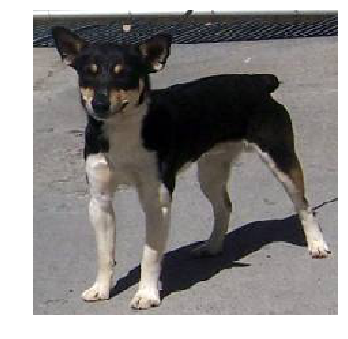

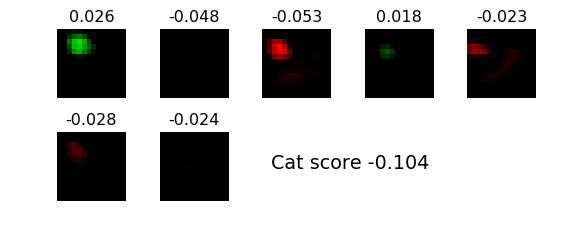

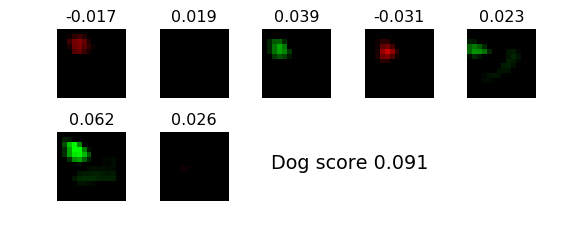

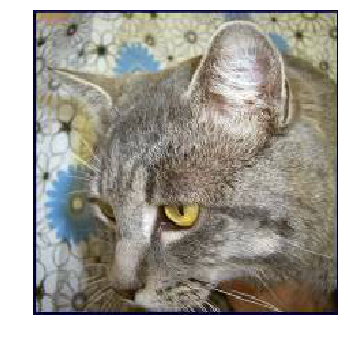

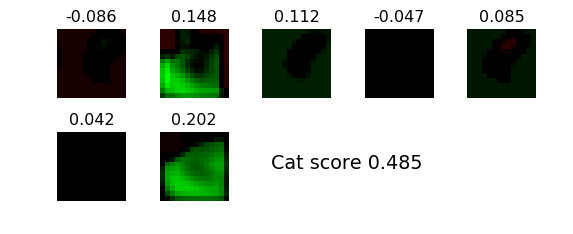

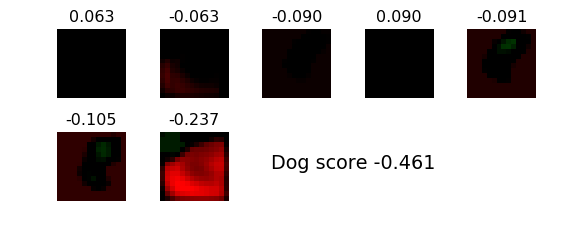

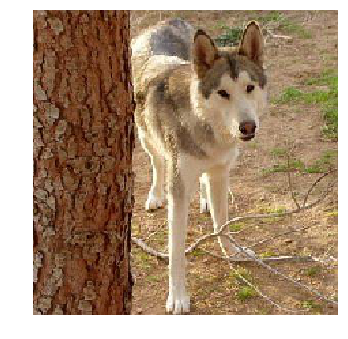

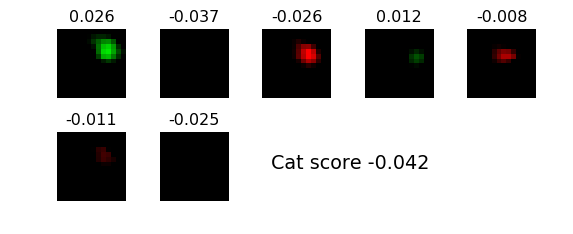

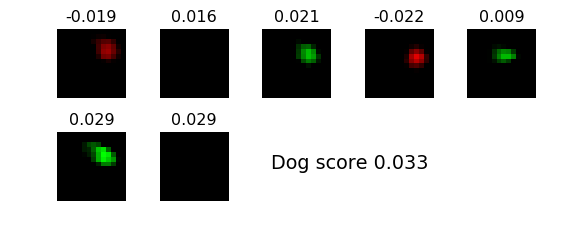

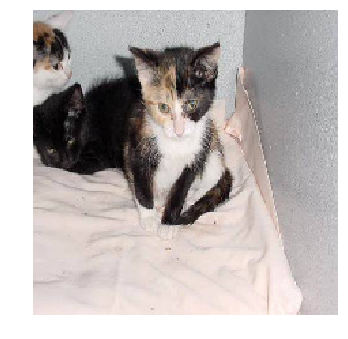

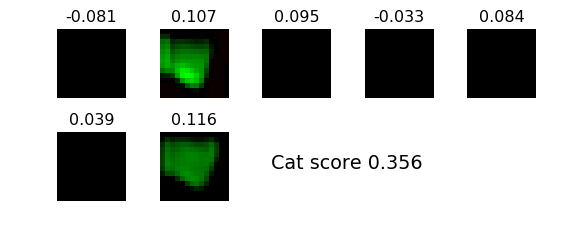

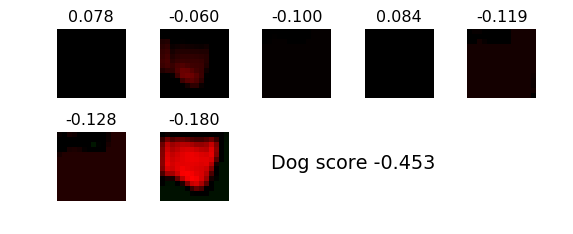

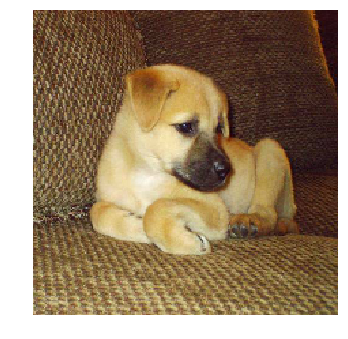

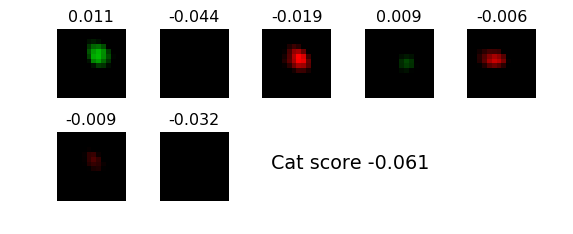

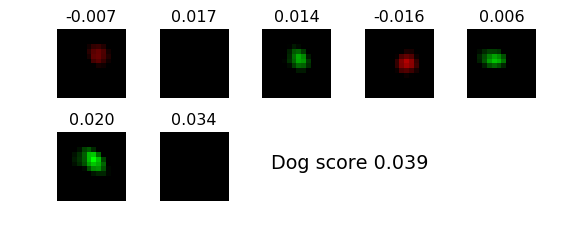

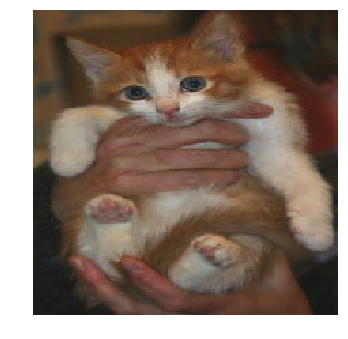

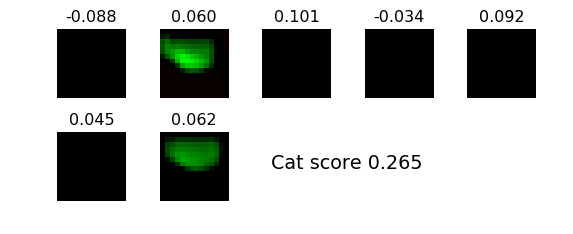

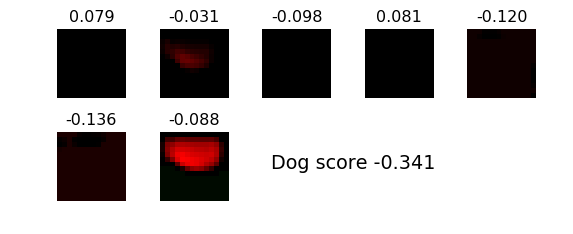

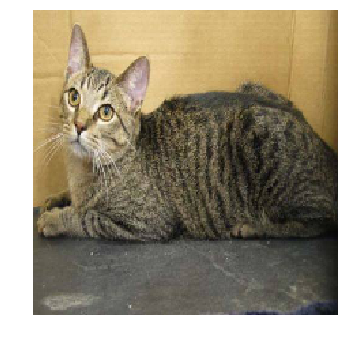

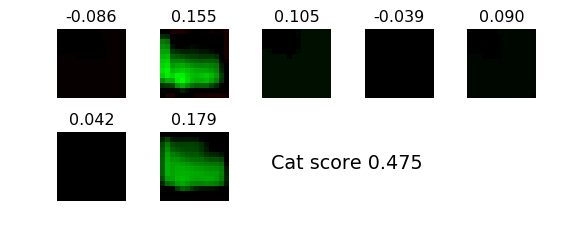

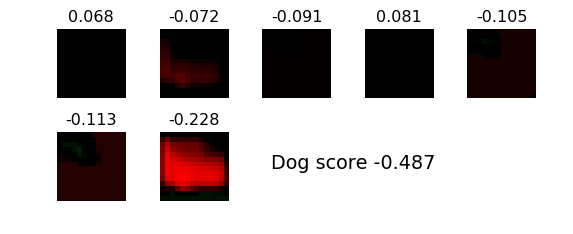

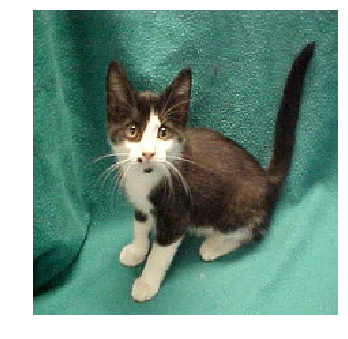

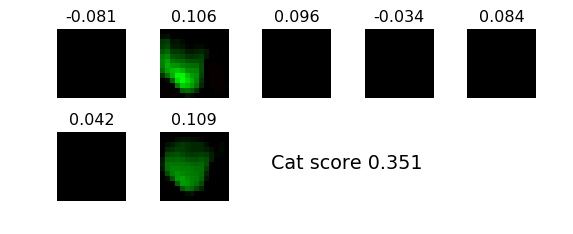

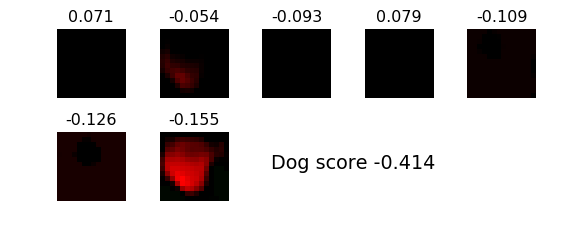

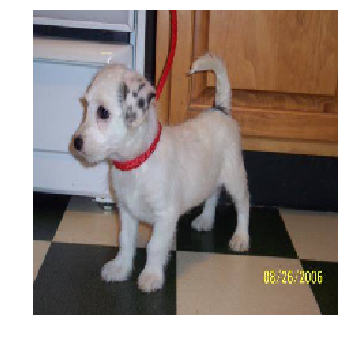

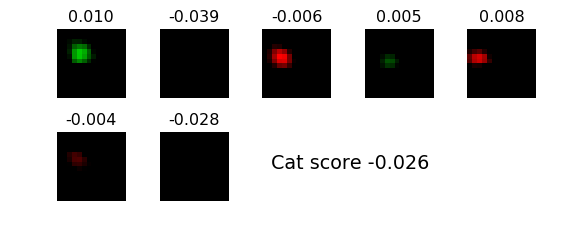

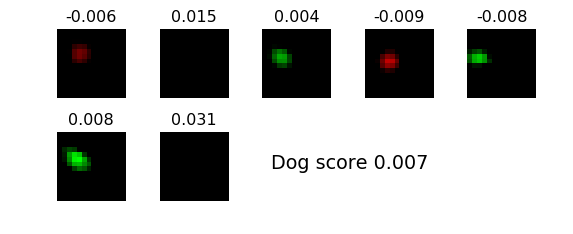

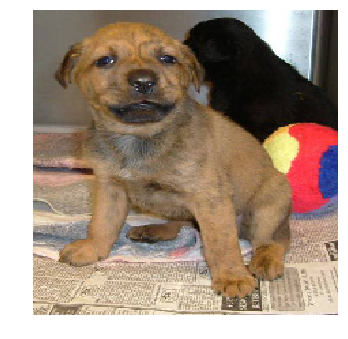

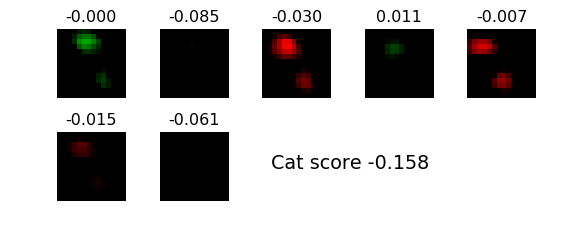

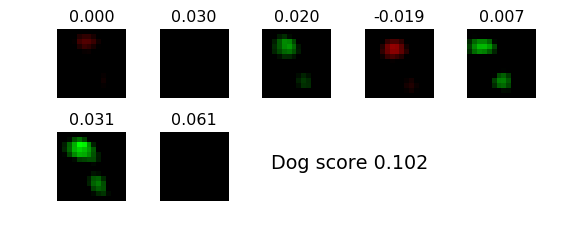

In [320]:

### THE PADDING IS MESSING THIS UP
### Putting visualization together

from tensorflow.python.keras.optimizers import SGD, RMSprop, Adam, Nadam
from tensorflow import keras as K
from tensorflow.python.keras.models import Sequential, Model
from matplotlib import figure
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import NoNorm

### Visualization
def get_vis(model, input):
    m2 = Sequential()
    target_layer=len(model.layers)-6
#    print("Target_layer",model.layers[target_layer].name)
    for i in range(0,target_layer):
        m2.add(model.layers[i])
    return m2.predict(input)

def Visualize(single_input):
    input = single_input[0:]
    plots(input)
    outp = get_vis(m1.model, input)
    return outp
    
def plot_the_other_way(data, averages, txt):
    cnt = min(data.shape[0],64)
    row_len = 5
    col_num = int(cnt/row_len + 1)
    pix_per_image = 112
    border = 2
    pix_w = (pix_per_image+border) * row_len
    pix_h = (pix_per_image+border) * col_num
    dpi= 96
    f = plt.figure(figsize=(pix_w/dpi,pix_h/dpi),dpi=dpi)
    plt.axis('off')
    plt.text(0.45, 0.19, txt, size='x-large')
    nonorm = NoNorm()
    for t in range(0,cnt):
        slice = data[t]
        ims = np.array(slice).astype(np.uint8)
        sp = f.add_subplot(col_num, row_len, t+1)
        plt.subplots_adjust(left=0,hspace=0.5, wspace = 0.0)        
        plt.imshow(ims, cmap="BlueRed1", norm=nonorm)
        sp.set_title("{0:.3f}".format(averages[t]))
        plt.axis('off')

def normalize(arr):
    global_min = 10000
    global_max = -global_min
    for t in arr:
        mn = np.amin(t)
        mx = np.amax(t)
        global_min = min(global_min,mn)
        global_max = max(global_max,mx)
    global_max = max(global_max, abs(global_min))
    global_min = -global_max
    global_range = global_max - global_min
    for i in range(0,len(arr)):
        arr[i] = arr[i] - global_min
        arr[i] = arr[i] / global_range
    
def generate_class_view(data, name, weights, bias):
    ### Slice data
    out_data = []
    wgts = []
    for i in range(0,len(weights)):
        slice = data[0][:,:,i] * weights[i] * 2
        out_data.append(slice)

    ar2 = np.asarray(out_data)
    # Remove padding (2 around all edges)
    # This works because the first [] remove extents by 2, and then the second [] index into that
    ar2 = ar2[:,:-2,:-2][:,2:,2:]
    normalize(ar2)

    # Simulate averages
    averages = []
    for i in range(0, len(ar2)):
        averages.append((np.average(ar2[i])-0.5))

    txt = "{0} score {1:.3f}".format(name, sum(averages)+bias)
    plot_the_other_way(ar2*255, averages, txt)
#    np.set_printoptions(precision=0, suppress=True)
#    print(ar2[4]*100)

def breakdown_single_image(outp):
    ## Get layer weights
    layer = m1.model.layers[-1]
    w = layer.get_weights()
    cat_weights = w[0][:,0]
    cat_bias = w[1][0]
    dog_weights = w[0][:,1]
    dog_bias = w[1][1]

    cdict1 = {'red':   ((0.0, 1.0, 1.0),
                       (0.4, 0.0, 0.0),
                       (1.0, 0.0, 0.0)),

             'green': ((0.0, 0.0, 0.0),
                       (0.6, 0.0, 0.0),
                       (1.0, 1.0, 1.0)),

             'blue':  ((0.0, 0.0, 0.0),
                       (0.6, 0.0, 0.0),
                       (1.0, 0.0, 0.0))
            }
    generate_class_view(outp, "Cat", cat_weights, cat_bias)    
    generate_class_view(outp, "Dog", dog_weights, dog_bias)

blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1)
plt.register_cmap(cmap=blue_red1)
single_input = batches_train.iter.next()[0]

for i in range(0,10):
    single_input = batches_train.iter.next()[0]
    outp = Visualize(single_input)
    breakdown_single_image(outp)


In [257]:
### Get single input
single_input = batches_train.iter.next()[0]


(1, 224, 224, 3)
<class 'numpy.ndarray'>
Model says this is a [[ 1.  0.]]
Target_layer cblock_3_conv
Output shape (1, 18, 18, 7) 7


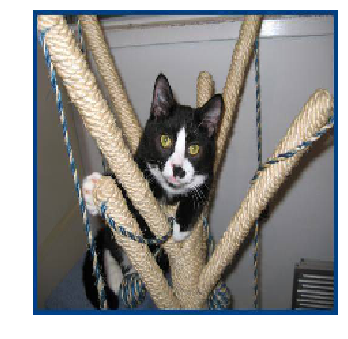

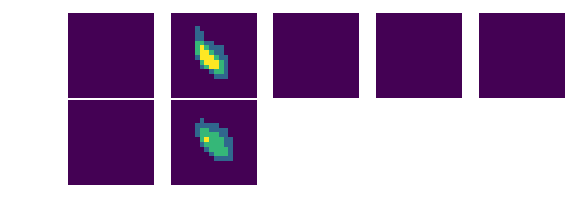

In [315]:
### Create model and get layer outputs
from tensorflow.python.keras.optimizers import SGD, RMSprop, Adam, Nadam
from tensorflow import keras as K
from tensorflow.python.keras.models import Sequential, Model
from matplotlib import figure

### Visualization
def get_vis(model, input):
    m2 = Sequential()
    target_layer=len(model.layers)-6
    print("Target_layer",model.layers[target_layer].name)
    for i in range(0,target_layer):
        m2.add(model.layers[i])
    return m2.predict(input)

def plot_old(data):
    cnt = min(data.shape[-1],64)
    row_len = 5
    col_num = int(cnt/row_len + 1)
    pix_per_image = 112
    border = 2
    pix_w = (pix_per_image+border) * row_len
    pix_h = (pix_per_image+border) * col_num
    dpi= 96
    sbp = figure.SubplotParams(wspace = 0)
    f = plt.figure(figsize=(pix_w/dpi,pix_h/dpi),dpi=dpi)
    plt.margins(x=0,y=0)
    plt.axis('off')
    plt.autoscale(tight = True)
    for t in range(0,cnt):
        slice = data[0][:,:,t]
        ims = np.array(slice).astype(np.uint8)
        f.add_subplot(col_num, row_len, t+1)
        plt.subplots_adjust(left=0,hspace=0.02, wspace = 0.0)
        plt.imshow(ims)
        plt.axis('off')

def plot_new(data):
    cnt = min(data.shape[-1],64)
    row_len = 5
    col_num = int(cnt/row_len + 1)
    pix_per_image = 112
    border = 2
    pix_w = (pix_per_image+border) * row_len + 100
    pix_h = (pix_per_image+border) * col_num + 100
    dpi= 96
    sbp = figure.SubplotParams(wspace = 0)
    f = plt.figure(figsize=(pix_w/dpi,pix_h/dpi),dpi=dpi)
    plt.margins(x=0,y=0)
    plt.axis('off')
    plt.autoscale(tight = True)
    for t in range(0,cnt):
        slice = data[0][:,:,t]
        ims = np.array(slice).astype(np.uint8)
        x = t % row_len
        y = int(t / row_len)
        plt.figimage(ims, xo = x*(pix_per_image+2), yo=y*(pix_per_image+2))

input = single_input[2:3]
print(input.shape)
print(type(input[0]))
plots(input)
print("Model says this is a",m1.model.predict(input))
outp = get_vis(m1.model, input)
print("Output shape",outp.shape,outp.shape[-1])
plot_old(outp)
### print(outp[:,:,:,6])

Layer top_output
{'name': 'top_output', 'trainable': True, 'dtype': 'float32', 'units': 2, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Layer get_weights returned an array of 2
Weights shape (7, 2)
Biases shape (2,)
Cat weights [ 0.844  0.877 -0.938  0.429 -0.901 -0.473  0.707]
Dog weights [-0.524 -0.314  0.635 -0.703  0.818  0.993 -0.702]
Biases [ 0.028 -0.028]
Dog bias -0.028004

Dog analysis
Averages [ 0.065  0.106 -0.093  0.047 -0.102 -0.145  0.222]
Sum of averages 0.073
[[ 65.  65.  65.  65.  65.  65.  65.  65.  65.  63.  65.  65.  65.  65.]
 [ 65.  65.  65.  65.  65.  65.  65.  65.  59.  55.  65.  65.  65.  65.]


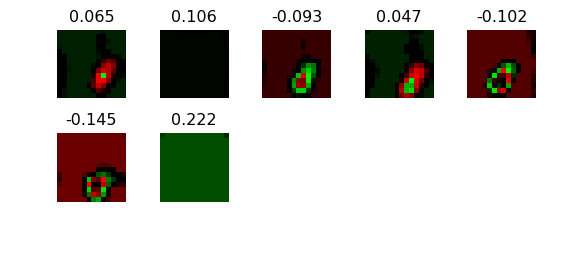

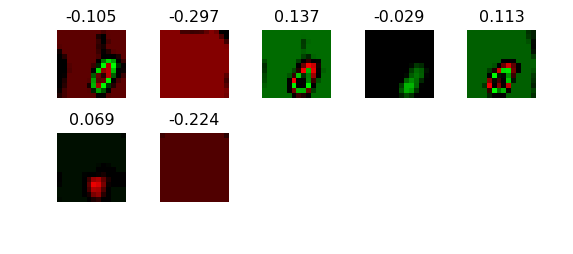

In [334]:
### Show cat and dog visualizations

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import NoNorm
## Get layer weights
np.set_printoptions(precision=3, suppress=True)

layer = m1.model.layers[-1]
print("Layer", layer.name)
print(layer.get_config())
w = layer.get_weights()
print("Layer get_weights returned an array of", len(w))
print("Weights shape", w[0].shape)
print("Biases shape", w[1].shape)
cat_weights = w[0][:,0]
cat_bias = w[1][0]
dog_weights = w[0][:,1]
dog_bias = w[1][1]
print("Cat weights", cat_weights)
print("Dog weights", dog_weights)
print("Biases", w[1])
print("Dog bias", dog_bias)
      

cdict1 = {'red':   ((0.0, 1.0, 1.0),
                   (0.4, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'green': ((0.0, 0.0, 0.0),
                   (0.6, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (0.6, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1)
plt.register_cmap(cmap=blue_red1)

def plot_the_other_way(data, averages):
    cnt = min(data.shape[0],64)
    row_len = 5
    col_num = int(cnt/row_len + 1)
    pix_per_image = 112
    border = 2
    pix_w = (pix_per_image+border) * row_len
    pix_h = (pix_per_image+border) * col_num
    dpi= 96
    f = plt.figure(figsize=(pix_w/dpi,pix_h/dpi),dpi=dpi)
    plt.axis('off')
    nonorm = NoNorm()
    for t in range(0,cnt):
        slice = data[t]
        ims = np.array(slice).astype(np.uint8)
        sp = f.add_subplot(col_num, row_len, t+1)
        plt.subplots_adjust(left=0,hspace=0.5, wspace = 0.0)        
        plt.imshow(ims, cmap="BlueRed1", norm=nonorm)
        sp.set_title("{0:.3f}".format(averages[t]))
        plt.axis('off')
        plt.xlabel("Bar")

def normalize(arr):
    global_min = 10000
    global_max = -global_min
    for t in arr:
        mn = np.amin(t)
        mx = np.amax(t)
        global_min = min(global_min,mn)
        global_max = max(global_max,mx)
    global_min = -2
    global_max = 2
    global_max = max(global_max, abs(global_min))
    global_min = -global_max
    global_range = global_max - global_min
    for i in range(0,len(arr)):
        arr[i] = arr[i] - global_min
        arr[i] = arr[i] / global_range
    
def generate_class_view(data, name, weights, bias):
    ### Slice data
    out_data = []
    wgts = []
    for i in range(0,len(weights)):
        slice = data[0][:,:,i] * weights[i] * 2
        out_data.append(slice)

    ar2 = np.asarray(out_data)
    # Remove padding (2 around all edges)
    # This works because the first [] remove extents by 2, and then the second [] index into that
    ar2 = ar2[:,:-2,:-2][:,2:,2:]
    normalize(ar2)

    # Simulate averages
    averages = []
    for i in range(0, len(ar2)):
        averages.append((np.average(ar2[i])-0.5))
    print("\n{0} analysis".format(name))
    print("Averages", np.asarray(averages))
    print("Sum of averages {0:.3f}".format((sum(averages)+bias)))

    plot_the_other_way(ar2*255, averages)
    np.set_printoptions(precision=0, suppress=True)
    print(ar2[0]*100)


generate_class_view(outp, "Dog", dog_weights, dog_bias)
generate_class_view(outp, "Cat", cat_weights, cat_bias)

(1, 224, 224, 3)

Dog analysis
Averages [-0.  0.  0. -0.  0.  0.  0.]
Sum of averages 0.291
[[ 57.  57.  56.  53.  50.  48.  47.  48.  48.  46.  44.  42.  46.  51.]
 [ 57.  57.  55.  49.  43.  40.  39.  40.  40.  38.  34.  32.  37.  45.]
 [ 57.  57.  53.  45.  38.  34.  33.  34.  34.  32.  27.  23.  28.  37.]
 [ 57.  57.  51.  42.  35.  32.  31.  32.  34.  32.  25.  20.  25.  35.]
 [ 57.  57.  51.  42.  35.  32.  32.  33.  35.  35.  28.  21.  25.  35.]
 [ 57.  57.  53.  45.  37.  33.  32.  34.  36.  36.  30.  24.  28.  37.]
 [ 57.  57.  53.  46.  39.  33.  32.  34.  37.  38.  34.  29.  33.  40.]
 [ 57.  57.  53.  48.  41.  36.  35.  37.  40.  42.  41.  38.  39.  44.]
 [ 57.  56.  52.  49.  45.  41.  39.  41.  44.  48.  50.  48.  48.  49.]
 [ 57.  55.  52.  51.  49.  47.  46.  47.  49.  53.  57.  57.  57.  56.]
 [ 57.  55.  52.  53.  53.  54.  53.  52.  54.  57.  57.  57.  57.  57.]
 [ 57.  55.  53.  54.  55.  55.  55.  54.  55.  57.  57.  57.  57.  57.]
 [ 56.  55.  54.  56.  56.  55. 

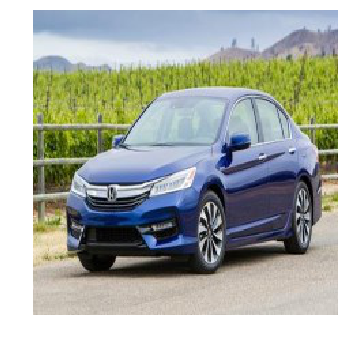

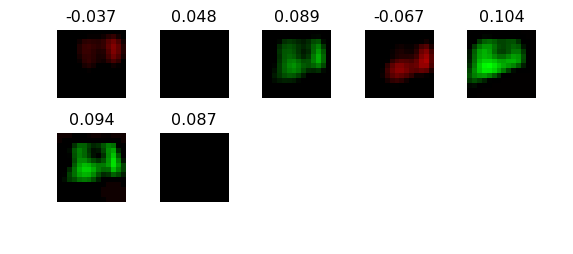

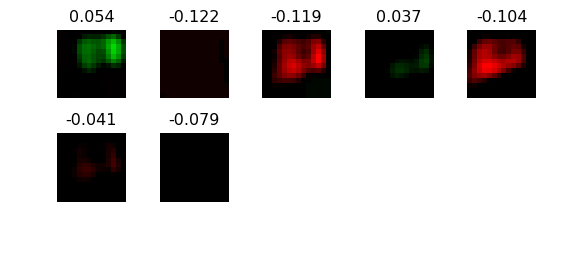

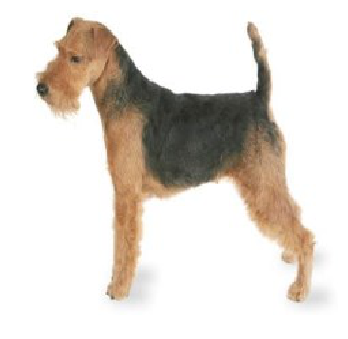

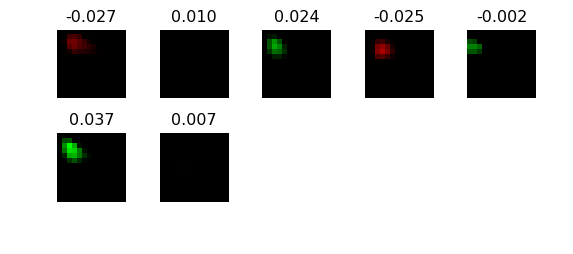

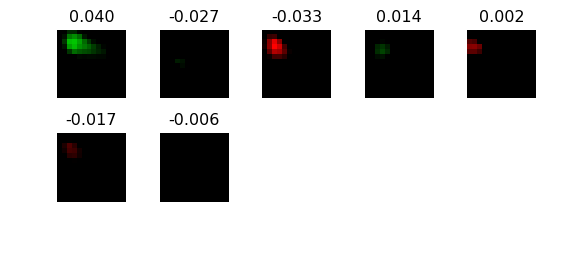

In [333]:
from PIL import Image as pil_image
def readjpg(fname):
    img = pil_image.open(fname)
    data_format='channels_last'
    x = np.asarray(img, dtype=K.backend.floatx())
    if len(x.shape) == 3:
        if data_format == 'channels_first':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if data_format == 'channels_first':
            x = x.reshape((1, x.shape[0], x.shape[1]))
    else:
        x = x.reshape((x.shape[0], x.shape[1], 1))
    y = []
    y.append(x)
    y = np.asarray(y)
    return img, y

def runtest(fname):
    img,x = readjpg(fname)
    print(x.shape)
    outp = Visualize(x)
    # breakdown_single_image(outp)
    generate_class_view(outp, "Dog", dog_weights, dog_bias)
    generate_class_view(outp, "Cat", cat_weights, cat_bias)
    
runtest("nondogcat.jpg")
runtest("dog.jpg")

In [5]:
# Run epochs
print(batches_train.batch_size*batches_train.step_count())
hist = m1.train(batches_train, batches_valid, epochs=15)

5752.0
Using cached mode (skipping non-trainable steps)
Epoch 1/15
177/179 [============================>.] - ETA: 0s - loss: 0.0474 - acc: 0.9861
Best epoch, needs to be saved. Current:0.032  old_best:0.045
Saving model checkpoint to d:/temp/ml/nincode/model1\180101-121417_0.032.checkpoint
Deleting inferior checkpoint d:/temp/ml/nincode/model1\180101-121320_0.050.checkpoint
180/179 [==============================] - 3s - loss: 0.0474 - acc: 0.9861 - val_loss: 0.0322 - val_acc: 0.9905
Epoch 2/15
180/179 [==============================] - 3s - loss: 0.0335 - acc: 0.9878 - val_loss: 0.0578 - val_acc: 0.9810
Epoch 3/15
180/179 [==============================] - 3s - loss: 0.0360 - acc: 0.9873 - val_loss: 0.0750 - val_acc: 0.9775
Epoch 4/15
180/179 [==============================] - 3s - loss: 0.0381 - acc: 0.9877 - val_loss: 0.0406 - val_acc: 0.9880
Epoch 5/15
180/179 [==============================] - 3s - loss: 0.0363 - acc: 0.9877 - val_loss: 0.0513 - val_acc: 0.9800
Epoch 6/15
180/179

In [4]:
### Deep summary and visualization
import os
from tensorflow.python.keras._impl.keras.utils.vis_utils import plot_model
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
plot_model(m1.model, to_file='model_plot.png', show_shapes=True)


In [5]:
### CACHE
if False:
    cached_valid = m1.precache_batch(batches_valid)
    cached_train = m1.precache_batch(batches_train)
    # Probably want to reload at this point

Caching valid
Cached model - using output of block5_conv3
2000/2000 [==============================] - 11s    
(2000, 14, 14, 512)
Saving d:/temp/dogscats/cached_valid_data
Saving d:/temp/dogscats/cached_valid_labels
Caching train
23000/23000 [==============================] - 150s   
(23000, 14, 14, 512)
Saving d:/temp/dogscats/cached_train_data
Saving d:/temp/dogscats/cached_train_labels


In [ ]:
### 8 CPUs
Epoch 1/2
23000/23000 [==============================] - 9113s - loss: 0.1929 - acc: 0.9390 - val_loss: 0.2346 - val_acc: 0.9575


### GeForce 1080 stats, 32*8
Epoch 1/3
23000/23000 [==============================] - 80s - loss: 0.1746 - acc: 0.9581 - val_loss: 0.1573 - val_acc: 0.9725
Epoch 2/3
23000/23000 [==============================] - 75s - loss: 0.0480 - acc: 0.9826 - val_loss: 0.0614 - val_acc: 0.9835
Epoch 3/3
23000/23000 [==============================] - 75s - loss: 0.0401 - acc: 0.9862 - val_loss: 0.0551 - val_acc: 0.9825                

### GeForce 1080 stats, 32*8 Ubuntu
Epoch 1/3
23000/23000 [==============================] - 41s - loss: 0.1839 - acc: 0.9593 - val_loss: 0.0845 - val_acc: 0.9800
Epoch 2/3
23000/23000 [==============================] - 41s - loss: 0.0447 - acc: 0.9848 - val_loss: 0.0515 - val_acc: 0.9825
Epoch 3/3
23000/23000 [==============================] - 42s - loss: 0.0373 - acc: 0.9861 - val_loss: 0.0478 - val_acc: 0.9825

                
### GeForce 1080 stats, 32*4
Epoch 1/10
23000/23000 [==============================] - 89s - loss: 0.1013 - acc: 0.9708 - val_loss: 0.0545 - val_acc: 0.9815
Epoch 2/10
23000/23000 [==============================] - 85s - loss: 0.0425 - acc: 0.9849 - val_loss: 0.0521 - val_acc: 0.9775
Epoch 3/10
23000/23000 [==============================] - 85s - loss: 0.0391 - acc: 0.9863 - val_loss: 0.0601 - val_acc: 0.9780
                
### GeForce 1080 stats, 32
Train on 23000 samples, validate on 2000 samples # 32
Epoch 1/10
23000/23000 [==============================] - 153s - loss: 0.1050 - acc: 0.9661 - val_loss: 0.0551 - val_acc: 0.9790
Epoch 2/10
23000/23000 [==============================] - 150s - loss: 0.0503 - acc: 0.9815 - val_loss: 0.0430 - val_acc: 0.9830
Epoch 3/10
23000/23000 [==============================] - 150s - loss: 0.0392 - acc: 0.9862 - val_loss: 0.0651 - val_acc: 0.9835
                
                
### K80 GCP, single GPU, 32*4
Train on 23000 samples, validate on 2000 samples
Epoch 1/10
23000/23000 [==============================] - 102s - loss: 0.1392 - acc: 0.9634 - val_loss: 0.1263 - val_acc: 0.9635
Epoch 2/10
23000/23000 [==============================] - 97s - loss: 0.0466 - acc: 0.9831 - val_loss: 0.0369 - val_acc: 0.9840
Epoch 3/10
23000/23000 [==============================] - 96s - loss: 0.0390 - acc: 0.9858 - val_loss: 0.0493 - val_acc: 0.9805
                
### K80 GCP, single GPU, 32*16
Epoch 1/3
23000/23000 [==============================] - 86s - loss: 0.3212 - acc: 0.9398 - val_loss: 0.4803 - val_acc: 0.9460
Epoch 2/3
23000/23000 [==============================] - 86s - loss: 0.0532 - acc: 0.9821 - val_loss: 0.1181 - val_acc: 0.9775
Epoch 3/3
23000/23000 [==============================] - 85s - loss: 0.0386 - acc: 0.9862 - val_loss: 0.0653 - val_acc: 0.9820
                
### 2xK80 GCP, multiple GPU, 500
Epoch 1/3
23000/23000 [==============================] - 59s - loss: 0.3866 - acc: 0.9328 - val_loss: 0.3760 - val_acc: 0.9470
Epoch 2/3
23000/23000 [==============================] - 53s - loss: 0.0493 - acc: 0.9818 - val_loss: 0.0792 - val_acc: 0.9760
Epoch 3/3
23000/23000 [==============================] - 53s - loss: 0.0412 - acc: 0.9847 - val_loss: 0.0459 - val_acc: 0.9810
                
### 4xK80 GCP, multiple GPU, 32*4
Epoch 1/10
23000/23000 [==============================] - 55s - loss: 0.1422 - acc: 0.9600 - val_loss: 0.0524 - val_acc: 0.9815
Epoch 2/10
23000/23000 [==============================] - 52s - loss: 0.0594 - acc: 0.9791 - val_loss: 0.0453 - val_acc: 0.9815
Epoch 3/10
23000/23000 [==============================] - 52s - loss: 0.0496 - acc: 0.9812 - val_loss: 0.0433 - val_acc: 0.9835
Epoch 4/10
23000/23000 [==============================] - 52s - loss: 0.0319 - acc: 0.9878 - val_loss: 0.0398 - val_acc: 0.9835    

### 4xK80 GCP, multiple GPU, 500
Epoch 1/3
23000/23000 [==============================] - 36s - loss: 0.2498 - acc: 0.9450 - val_loss: 0.0866 - val_acc: 0.9735
Epoch 2/3
23000/23000 [==============================] - 31s - loss: 0.0601 - acc: 0.9797 - val_loss: 0.0615 - val_acc: 0.9785
Epoch 3/3
23000/23000 [==============================] - 32s - loss: 0.0474 - acc: 0.9829 - val_loss: 0.0550 - val_acc: 0.9795

                
### P100, GCP, single GPU, 32*16 (32*4 = +2ms)
Epoch 1/3
23000/23000 [==============================] - 33s - loss: 0.3105 - acc: 0.9368 - val_loss: 4.9008 - val_acc: 0.5945
Epoch 2/3
23000/23000 [==============================] - 30s - loss: 0.0522 - acc: 0.9804 - val_loss: 0.4187 - val_acc: 0.9210
Epoch 3/3
23000/23000 [==============================] - 30s - loss: 0.0431 - acc: 0.9846 - val_loss: 0.1111 - val_acc: 0.9745
                
### 2xP100, GCP, 500
Epoch 1/3
23000/23000 [==============================] - 24s - loss: 0.4610 - acc: 0.9093 - val_loss: 4.4569 - val_acc: 0.6455
Epoch 2/3
23000/23000 [==============================] - 22s - loss: 0.0619 - acc: 0.9789 - val_loss: 0.6196 - val_acc: 0.8930
Epoch 3/3
23000/23000 [==============================] - 22s - loss: 0.0463 - acc: 0.9834 - val_loss: 0.1690 - val_acc: 0.9635
                
### 4xP100, GCP, multiple GPU, 32*16
Epoch 1/3
23000/23000 [==============================] - 19s - loss: 0.3134 - acc: 0.9329 - val_loss: 0.1129 - val_acc: 0.9680
Epoch 2/3
23000/23000 [==============================] - 17s - loss: 0.0625 - acc: 0.9781 - val_loss: 0.0632 - val_acc: 0.9800
Epoch 3/3
23000/23000 [==============================] - 18s - loss: 0.0478 - acc: 0.9825 - val_loss: 0.0543 - val_acc: 0.9795 
                
### 4xP100, GCP, multiple GPU, 500
Epoch 1/3
23000/23000 [==============================] - 18s - loss: 0.2697 - acc: 0.9440 - val_loss: 0.1147 - val_acc: 0.9745
Epoch 2/3
23000/23000 [==============================] - 16s - loss: 0.0587 - acc: 0.9796 - val_loss: 0.0579 - val_acc: 0.9825
Epoch 3/3
23000/23000 [==============================] - 16s - loss: 0.0482 - acc: 0.9822 - val_loss: 0.0540 - val_acc: 0.9815

(2000, 14, 14, 512)
(23000, 14, 14, 512)
imgs    (23000, 224, 224, 3)
labels  (23000, 2)


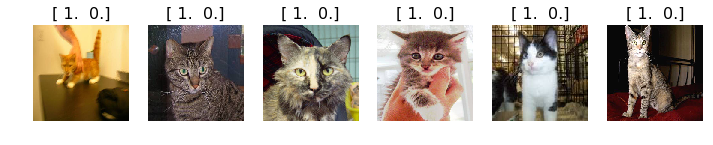

In [3]:
# Save intermediate output - process

Do you really want to rerun this?

import bcolz
def save_array(fname, arr): 
    c=bcolz.carray(arr, rootdir='.bcolz/'+fname, mode='w')
    c.flush()
def load_array(fname): 
    print("Loading",fname)
    return bcolz.open('.bcolz/'+fname)[:]

def get_data(batches):
    cnt = int(batches.samples/batches.batch_size)
    imgs = np.concatenate([batches.next()[0] for i in range(cnt)])
    labels = np.concatenate([batches.next()[1] for i in range(cnt)])
    return imgs, labels

def cache_output(batches):
    cnt = int(batches.samples/batches.batch_size)
    imgs = np.concatenate([batches.next()[0] for i in range(cnt)])
#    labels = np.concatenate([batches.next()[1] for i in range(cnt)])
    y = top_model.predict(imgs)
    print(y.shape)
    return y


imgs, labels = get_data(batches_valid)
save_array("batches_valid_imgs", imgs)
save_array("batches_valid_labels", labels)
y = cache_output(batches_valid)
save_array("batches_valid_processed", y)

imgs, labels = get_data(batches_train)
save_array("batches_train_imgs", imgs)
save_array("batches_train_labels", labels)
y = cache_output(batches_train)
save_array("batches_train_processed", y)

print('imgs   ',imgs.shape)
print('labels ',labels.shape)
plots(imgs[0:6], titles=labels[0:6])


Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [2]:
# path = "data/dogscats/"
path = "data/dogscats/sample/"

A few basic libraries that we'll need for the initial exercises:

In [3]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [4]:
import utils
from importlib import reload
reload(utils)
from utils import plots

# Use a pretrained VGG model with our **Vgg16** class

Our first step is simply to use a model that has been fully created for us, which can recognise a wide variety (1,000 categories) of images. We will use 'VGG', which won the 2014 Imagenet competition, and is a very simple model to create and understand. The VGG Imagenet team created both a larger, slower, slightly more accurate model (*VGG  19*) and a smaller, faster model (*VGG 16*). We will be using VGG 16 since the much slower performance of VGG19 is generally not worth the very minor improvement in accuracy.

We have created a python class, *Vgg16*, which makes using the VGG 16 model very straightforward. 

## The punchline: state of the art custom model in 7 lines of code

Here's everything you need to do to get >97% accuracy on the Dogs vs Cats dataset - we won't analyze how it works behind the scenes yet, since at this stage we're just going to focus on the minimum necessary to actually do useful work.

In [5]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64

In [2]:
# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16
import pydot
from tensorflow import keras as K
from tensorflow.python.keras.utils import get_file
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.utils import plot_model
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Flatten, Lambda, Dropout, BatchNormalization, ZeroPadding2D, Convolution2D, GlobalAveragePooling2D
from tensorflow.python.keras.optimizers import SGD, RMSprop, Adam

def get_classes():
    """
        Downloads the Imagenet classes index file and loads it to self.classes.
        The file is downloaded only if it not already in the cache.
    """
    fname = 'imagenet_class_index.json'
    FILE_PATH = 'http://files.fast.ai/models/'
    fpath = get_file(fname, FILE_PATH+fname, cache_subdir='models')
    with open(fpath) as f:
        class_dict = json.load(f)
    return [class_dict[str(i)][1] for i in range(len(class_dict))]


vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1, 3))
def vgg_preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.

        Args: 
            x: Image array (height x width x channels)
        Returns:
            Image array (height x width x transposed_channels)
    """
    x = x - vgg_mean
    return x[..., ::-1] # reverse axis rgb->bgr

classes = get_classes()
batch_size=50
vgg = VGG16(input_shape=(224,224,3), include_top=True, weights='imagenet')
vgg.trainable = False
layer_fc2 = vgg.get_layer(name='fc2')
layer_predictions = vgg.get_layer(name='predictions')
layer_block5_conv3 = vgg.get_layer(name='block5_conv3')    # Last 14x14 block
vgg.summary()
# vgg2 = Model(inputs=vgg.input, outputs=layer_fc2.output)
vgg2 = Model(inputs=vgg.input, outputs=layer_block5_conv3.output)

top_model = Sequential()
top_model.add(Lambda(vgg_preprocess,input_shape=(224,224,3)))
top_model.add(vgg2)
top_model.layers[1].trainable=False

top_model.add(ZeroPadding2D((2,2)))
top_model.add(Convolution2D(512, kernel_size=(5, 5), activation='relu'))
top_model.add(BatchNormalization())
top_model.add(Dropout(0.5))

top_model.add(ZeroPadding2D((2,2)))
top_model.add(Convolution2D(512, kernel_size=(5, 5), activation='relu'))
top_model.add(BatchNormalization())
top_model.add(Dropout(0.5))

top_model.add(ZeroPadding2D((2,2)))
top_model.add(Convolution2D(512, kernel_size=(5, 5), activation='relu'))
top_model.add(BatchNormalization())
top_model.add(Dropout(0.5))

top_model.add(ZeroPadding2D((2,2)))
top_model.add(Convolution2D(512, kernel_size=(5, 5), activation='relu'))
top_model.add(BatchNormalization())
top_model.add(Dropout(0.5))

# top_model.add(Dense(4096, activation='relu'))
# top_model.add(BatchNormalization())
# top_model.add(Dropout(0.1))
# top_model.add(Dense(4096, activation='relu'))
# top_model.add(BatchNormalization())
# top_model.add(Dropout(0.1))
# top_model.add(Dense(4096, activation='relu'))
# top_model.add(BatchNormalization())
# top_model.add(Dropout(0.1))
top_model.add(GlobalAveragePooling2D())
top_model.add(Dropout(0.2))
top_model.add(Dense(2, activation='softmax'))
top_model.compile(optimizer=Adam(lr=0.05), loss='categorical_crossentropy', metrics=['accuracy'])
top_model.summary()
batches_train = image.ImageDataGenerator().flow_from_directory(path+'train', target_size=(224,224), class_mode='categorical', shuffle=True, batch_size=batch_size)
batches_valid = image.ImageDataGenerator().flow_from_directory(path+'valid', target_size=(224,224), class_mode='categorical', shuffle=True, batch_size=batch_size)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

error - vgg                                                    process_model 
    0 - kelpie                         0.487                          kelpie 0.487
    0 - English_foxhound               0.575                English_foxhound 0.575
    0 - paper_towel                    0.191                     paper_towel 0.191
    0 - lynx                           0.164                            lynx 0.164
    0 - Egyptian_cat                   0.290                    Egyptian_cat 0.290
    0 - Great_Dane                     0.489                      Great_Dane 0.489


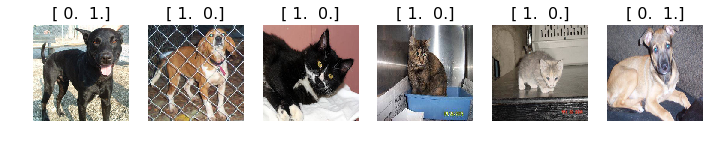

In [54]:
# Diagnostics
import math
from tensorflow.python.keras.applications.vgg16 import preprocess_input
imgs,labels = next(batches_train)
plots(imgs[0:6], titles=labels[0:6])
list(iter(batches_train.class_indices))

print("{4:s} - {0:30} {1}  {2:>30} {3:s}".format("vgg", "     ", "process_model","","error"))
for j in range(6):
    img = imgs[j]
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    predictions2 = process_model.predict(x)
    
#    pprint.pprint(x[0][0][0])
    x = preprocess_input(x)
#    pprint.pprint(x[0][0][0])
    
    predictions = vgg.predict(x)
    idxs = np.argmax(predictions, axis=1)
    idxs2 = np.argmax(predictions2, axis=1)
    error = math.pow(predictions2[0,idxs2[0]] - predictions[0,idxs[0]], 2) * 1000;
    print("{4:5.0f} - {0:30} {1:.3f}  {2:>30} {3:.3f}".format(classes[idxs[0]], predictions[0,idxs[0]], classes[idxs2[0]],predictions2[0,idxs2[0]], error))

In [4]:
# 156s - loss: 0.1056 - acc: 0.9671 - val_loss: 0.0863 - val_acc: 0.9635
# 920/920 [==============================] - 292s - loss: 0.0052 - acc: 0.9978 - val_loss: 0.0428 - val_acc: 0.9860
# 460/460 [==============================] - 254s - loss: 0.0123 - acc: 0.9956 - val_loss: 0.0499 - val_acc: 0.9875
# bn 150s - loss: 0.3090 - acc: 0.9789 - val_loss: 0.2685 - val_acc: 0.9820
steps=23000/batch_size
# steps=50
val_steps=2000/batch_size
# val_steps=10
num_epochs=1
top_model.compile(optimizer=Adam(lr=0.005), loss='categorical_crossentropy', metrics=['accuracy'])
top_model.fit_generator(batches_train, validation_data=batches_valid, epochs=num_epochs, steps_per_epoch=steps, validation_steps=val_steps)

num_epochs=2
top_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
top_model.fit_generator(batches_train, validation_data=batches_valid, epochs=num_epochs, steps_per_epoch=steps, validation_steps=val_steps)


num_epochs=1
top_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
top_model.fit_generator(batches_train, validation_data=batches_valid, epochs=num_epochs, steps_per_epoch=steps, validation_steps=val_steps)

SyntaxError: invalid syntax (<ipython-input-4-4ee4397a8b67>, line 3)

In [ ]:
# Found 23000 images belonging to 2 classes.
# Found 2000 images belonging to 2 classes.
# Epoch 1/1
# 23000/23000 [==============================] - 252s - loss: 0.1263 - acc: 0.9683 - val_loss: 0.0734 - val_acc: 0.9810

import vgg16; reload(vgg16)
from vgg16 import Vgg16
vgg = Vgg16()
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

The code above will work for any image recognition task, with any number of categories! All you have to do is to put your images into one folder per category, and run the code above.

Let's take a look at how this works, step by step...

## Use Vgg16 for basic image recognition

Let's start off by using the *Vgg16* class to recognise the main imagenet category for each image.

We won't be able to enter the Cats vs Dogs competition with an Imagenet model alone, since 'cat' and 'dog' are not categories in Imagenet - instead each individual breed is a separate category. However, we can use it to see how well it can recognise the images, which is a good first step.

First, create a Vgg16 object:

In [12]:
vgg = Vgg16()

Vgg16 is built on top of *Keras* (which we will be learning much more about shortly!), a flexible, easy to use deep learning library that sits on top of Theano or Tensorflow. Keras reads groups of images and labels in *batches*, using a fixed directory structure, where images from each category for training must be placed in a separate folder.

Let's grab batches of data from our training folder:

In [13]:
batches = vgg.get_batches(path+'train', batch_size=4)

Found 23000 images belonging to 2 classes.


(BTW, when Keras refers to 'classes', it doesn't mean python classes - but rather it refers to the categories of the labels, such as 'pug', or 'tabby'.)

*Batches* is just a regular python iterator. Each iteration returns both the images themselves, as well as the labels.

In [14]:
imgs,labels = next(batches)

As you can see, the labels for each image are an array, containing a 1 in the first position if it's a cat, and in the second position if it's a dog. This approach to encoding categorical variables, where an array containing just a single 1 in the position corresponding to the category, is very common in deep learning. It is called *one hot encoding*. 

The arrays contain two elements, because we have two categories (cat, and dog). If we had three categories (e.g. cats, dogs, and kangaroos), then the arrays would each contain two 0's, and one 1.

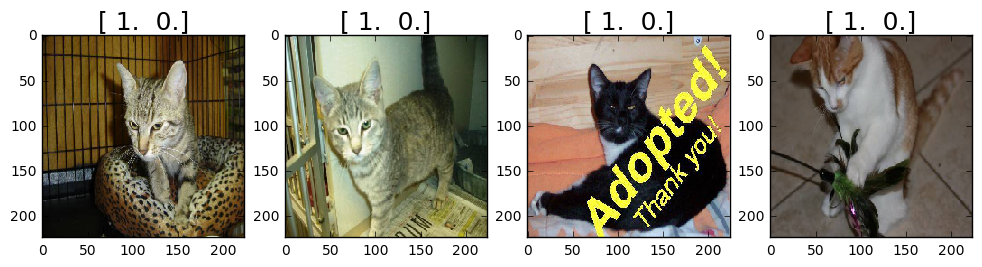

In [15]:
plots(imgs, titles=labels)

We can now pass the images to Vgg16's predict() function to get back probabilities, category indexes, and category names for each image's VGG prediction.

In [16]:
vgg.predict(imgs, True)

(array([ 0.9392,  0.3244,  0.1253,  0.1698], dtype=float32),
 array([285, 285, 478, 173]),
 [u'Egyptian_cat', u'Egyptian_cat', u'carton', u'Ibizan_hound'])

The category indexes are based on the ordering of categories used in the VGG model - e.g here are the first four:

In [17]:
vgg.classes[:4]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark']

(Note that, other than creating the Vgg16 object, none of these steps are necessary to build a model; they are just showing how to use the class to view imagenet predictions.)

## Use our Vgg16 class to finetune a Dogs vs Cats model

To change our model so that it outputs "cat" vs "dog", instead of one of 1,000 very specific categories, we need to use a process called "finetuning". Finetuning looks from the outside to be identical to normal machine learning training - we provide a training set with data and labels to learn from, and a validation set to test against. The model learns a set of parameters based on the data provided.

However, the difference is that we start with a model that is already trained to solve a similar problem. The idea is that many of the parameters should be very similar, or the same, between the existing model, and the model we wish to create. Therefore, we only select a subset of parameters to train, and leave the rest untouched. This happens automatically when we call *fit()* after calling *finetune()*.

We create our batches just like before, and making the validation set available as well. A 'batch' (or *mini-batch* as it is commonly known) is simply a subset of the training data - we use a subset at a time when training or predicting, in order to speed up training, and to avoid running out of memory.

In [18]:
batch_size=64

In [19]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Calling *finetune()* modifies the model such that it will be trained based on the data in the batches provided - in this case, to predict either 'dog' or 'cat'.

In [20]:
vgg.finetune(batches)

Finally, we *fit()* the parameters of the model using the training data, reporting the accuracy on the validation set after every epoch. (An *epoch* is one full pass through the training data.)

In [21]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 587s - loss: 0.1116 - acc: 0.9696 - val_loss: 0.0528 - val_acc: 0.9835


That shows all of the steps involved in using the Vgg16 class to create an image recognition model using whatever labels you are interested in. For instance, this process could classify paintings by style, or leaves by type of disease, or satellite photos by type of crop, and so forth.

Next up, we'll dig one level deeper to see what's going on in the Vgg16 class.

# Create a VGG model from scratch in Keras

For the rest of this tutorial, we will not be using the Vgg16 class at all. Instead, we will recreate from scratch the functionality we just used. This is not necessary if all you want to do is use the existing model - but if you want to create your own models, you'll need to understand these details. It will also help you in the future when you debug any problems with your models, since you'll understand what's going on behind the scenes.

## Model setup

We need to import all the modules we'll be using from numpy, scipy, and keras:

In [22]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Let's import the mappings from VGG ids to imagenet category ids and descriptions, for display purposes later.

In [23]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

Here's a few examples of the categories we just imported:

In [24]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

## Model creation

Creating the model involves creating the model architecture, and then loading the model weights into that architecture. We will start by defining the basic pieces of the VGG architecture.

VGG has just one type of convolutional block, and one type of fully connected ('dense') block. Here's the convolutional block definition:

In [25]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

...and here's the fully-connected definition.

In [26]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

When the VGG model was trained in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Furthermore, their software that expected the channels to be in B,G,R order, whereas Python by default uses R,G,B. We need to preprocess our data to make these two changes, so that it is compatible with the VGG model:

In [27]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

Now we're ready to define the VGG model architecture - look at how simple it is, now that we have the basic blocks defined!

In [28]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding patterns in images
- Dense (fully connected) layers are for combining patterns across an image

Now that we've defined the architecture, we can create the model like any python object:

In [29]:
model = VGG_16()

As well as the architecture, we need the weights that the VGG creators trained. The weights are the part of the model that is learnt from the data, whereas the architecture is pre-defined based on the nature of the problem. 

Downloading pre-trained weights is much preferred to training the model ourselves, since otherwise we would have to download the entire Imagenet archive, and train the model for many days! It's very helpful when researchers release their weights, as they did here.

In [30]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

## Getting imagenet predictions

The setup of the imagenet model is now complete, so all we have to do is grab a batch of images and call *predict()* on them.

In [31]:
batch_size = 4

Keras provides functionality to create batches of data from directories containing images; all we have to do is to define the size to resize the images to, what type of labels to create, whether to randomly shuffle the images, and how many images to include in each batch. We use this little wrapper to define some helpful defaults appropriate for imagenet data:

In [32]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

From here we can use exactly the same steps as before to look at predictions from the model.

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


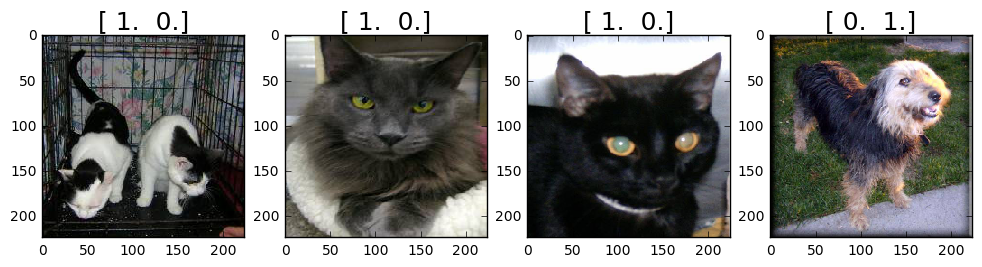

In [33]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

The VGG model returns 1,000 probabilities for each image, representing the probability that the model assigns to each possible imagenet category for each image. By finding the index with the largest probability (with *np.argmax()*) we can find the predicted label.

In [34]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [35]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  1.1169e-08   1.7160e-07   2.2501e-06   2.3426e-08   5.9417e-08]

Predictions prob/class: 
  0.2285/papillon
  0.2947/lynx
  0.6434/Egyptian_cat
  0.4845/Australian_terrier
